# Multiple Regression

This episode is a discussion of multiple regression: the use of observations that are a vector of values to predict a response variable.  For this episode, we consider how features of a home such as the number of bedrooms, number of bathrooms, and square footage can predict the sale price.

Unlike a typical episode of Data Skeptic, these show notes are not just supporting material, but are actually featured in the episode.

<!-- audio player -->

The site Redfin graciously allows users to download a CSV of results they are viewing.  Unfortunately, they limit this extract to 500 listings, but you can still use it to try the same approach on your own using the download link shown in the figure below.

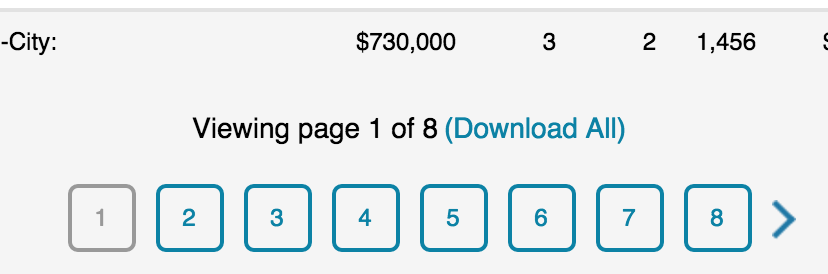

In [4]:
from IPython.display import Image
Image(filename='redfin.png', width=300)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math

## Data loading, cleaning, and munging

In [8]:
file = 'redfin_2016-02-06-20-27-26_results.csv'
df = pd.read_csv(file)

In [9]:
df['IS SHORT SALE'] = df['IS SHORT SALE'].fillna(0).astype(int)
df['LAST SALE DATE'] = pd.to_datetime(df['LAST SALE DATE'])
df['LAST SALE MONTH'] = df['LAST SALE DATE'].apply(lambda x: str(x.year) + '-' + str(x.month).zfill(2))
df['intercept'] = 1

In [10]:
df.columns

Index([u'SALE TYPE', u'HOME TYPE', u'ADDRESS', u'CITY', u'STATE', u'ZIP',
       u'LIST PRICE', u'BEDS', u'BATHS', u'LOCATION', u'SQFT', u'LOT SIZE',
       u'YEAR BUILT', u'PARKING SPOTS', u'PARKING TYPE', u'DAYS ON MARKET',
       u'STATUS', u'NEXT OPEN HOUSE DATE', u'NEXT OPEN HOUSE START TIME',
       u'NEXT OPEN HOUSE END TIME', u'RECENT REDUCTION DATE',
       u'ORIGINAL LIST PRICE', u'LAST SALE DATE', u'LAST SALE PRICE',
       u'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
       u'SOURCE', u'LISTING ID', u'ORIGINAL SOURCE', u'FAVORITE',
       u'INTERESTED', u'LATITUDE', u'LONGITUDE', u'IS SHORT SALE',
       u'LAST SALE MONTH', u'intercept'],
      dtype='object')

## Some miscellaneous data exploration

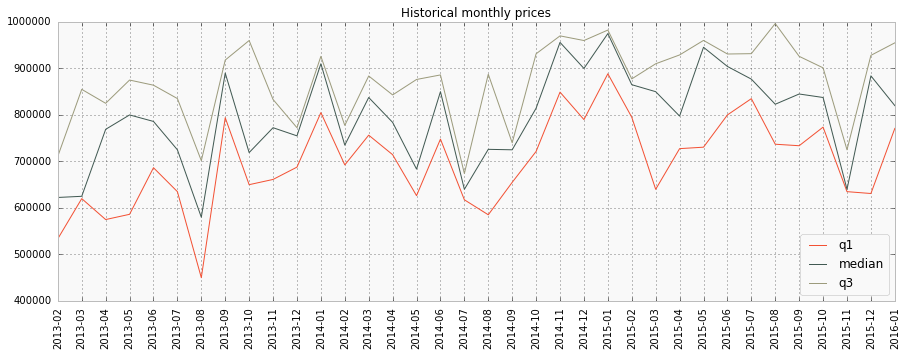

In [11]:
# Overall trend of prices for the input by month
h_mean = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].mean()
h_q1 = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].quantile(.25)
h_q2 = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].quantile(.5)
h_q3 = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].quantile(.75)
historical = pd.concat([h_q1, h_q2, h_q3, h_mean], axis=1)
historical.columns = ['q1', 'median', 'q3', 'mean']
historical = historical.reset_index()
plt.figure(figsize=(15,5))
#plt.plot(historical.index, historical['mean'])
plt.plot(historical.index, historical['q1'])
plt.plot(historical.index, historical['median'])
plt.plot(historical.index, historical['q3'])
plt.xticks(historical.index, historical['LAST SALE MONTH'], rotation=90)
plt.legend(loc=4)
plt.title('Historical monthly prices')
plt.show()

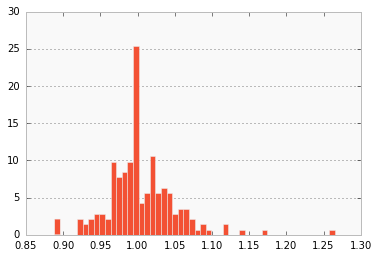

In [12]:
# RATIO OF LAST SALE PRICE TO LISTING PRICE (i.e. margin of negotation)
delta = df['LAST SALE PRICE'] / df['LIST PRICE']
delta.dropna(inplace=True)
n, bins, patches = plt.hist(delta, 50, normed=1)
plt.gca().xaxis.grid(False)

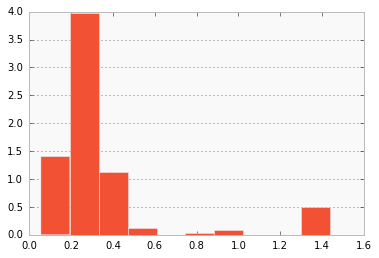

In [13]:
# RATIO OF SQFT TO LOT SIZE (just for fun)
delta = df['SQFT'] / df['LOT SIZE']
delta.dropna(inplace=True)
n, bins, patches = plt.hist(delta, 10, normed=1)
plt.gca().xaxis.grid(False)

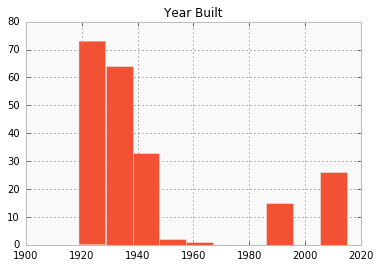

In [14]:
df['YEAR BUILT'].hist()
plt.title('Year Built')
plt.show()

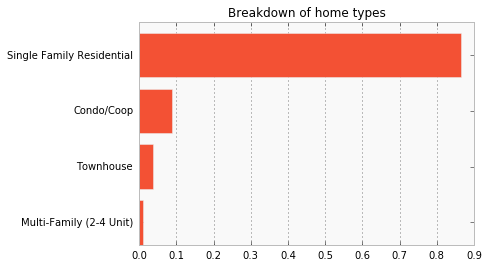

In [16]:
ht = df.groupby(['HOME TYPE'])['HOME TYPE'].count()
ht.sort_values(inplace=True)
ht = pd.DataFrame(ht)
ht.columns=['count']
ht['count'] = ht['count'] / sum(ht['count'])
ht.reset_index(inplace=True)
plt.barh(ht.index, ht['count'])
plt.yticks(ht.index + 0.4, ht['HOME TYPE'])
plt.gca().yaxis.grid(False)
plt.title('Breakdown of home types')
plt.show()

## Feature Exploration

Let's do some visualizations of our features before we blindly shove them into OLS.

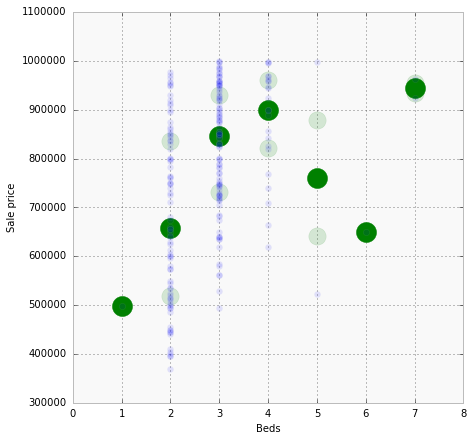

In [17]:
plt.figure(figsize=(7,7))
gb = df.groupby(['BEDS'])['LAST SALE PRICE'].median()
plt.scatter(gb.index, gb, color='green', s=400, alpha=1)
gb = df.groupby(['BEDS'])['LAST SALE PRICE'].quantile(.25)
plt.scatter(gb.index, gb, color='green', s=300, alpha=0.15)
gb = df.groupby(['BEDS'])['LAST SALE PRICE'].quantile(.75)
plt.scatter(gb.index, gb, color='green', s=300, alpha=0.15)
plt.scatter(df['BEDS'], df['LAST SALE PRICE'], alpha=0.1, s=40)
plt.xlabel('Beds')
plt.ylabel('Sale price')
plt.show()

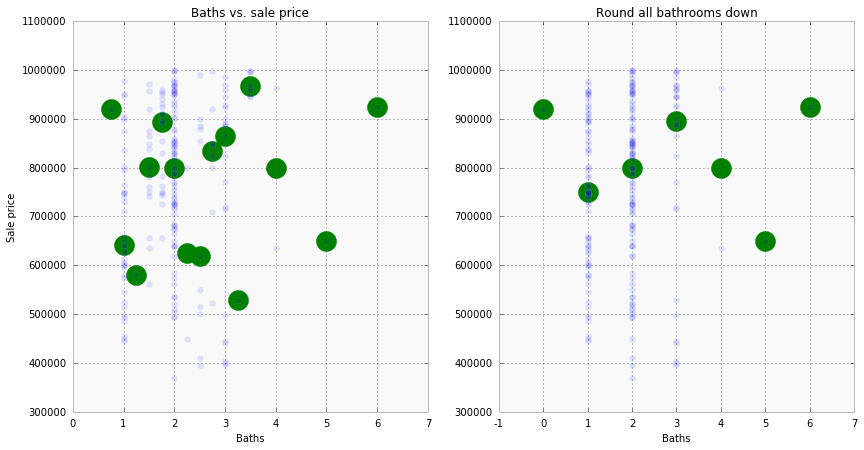

In [18]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)

df['fBATHS'] = df['BATHS'].apply(math.floor)

gb = df.groupby(['BATHS'])['LAST SALE PRICE'].median()
ax1.scatter(gb.index, gb, color='green', s=400, alpha=1)
ax1.scatter(df['BATHS'], df['LAST SALE PRICE'], alpha=0.1, s=40)
ax1.set_title('Baths vs. sale price')
ax1.set_xlabel('Baths')
ax1.set_ylabel('Sale price')

ax2 = fig.add_subplot(122)

gb = df.groupby(['fBATHS'])['LAST SALE PRICE'].median()
ax2.scatter(gb.index, gb, color='green', s=400, alpha=1)
ax2.scatter(df['fBATHS'], df['LAST SALE PRICE'], alpha=0.1, s=40)
ax2.set_title('Round all bathrooms down')
ax2.set_xlabel('Baths')

plt.show()

In [19]:
f = sm.OLS(df['LAST SALE PRICE'], df[['intercept', 'SQFT']], missing='drop').fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LAST SALE PRICE   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     76.43
Date:                Fri, 19 Feb 2016   Prob (F-statistic):           7.22e-16
Time:                        15:37:03   Log-Likelihood:                -2830.6
No. Observations:                 213   AIC:                             5665.
Df Residuals:                     211   BIC:                             5672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept   4.696e+05   3.59e+04     13.081      0.000      3.99e+05   5.4e+05
SQFT         196.2554     22.449      8.742      0.000       152.003   240.508
==============================================================================
Omnibus:                       19.384   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.991
Skew:                          -0.717   Prob(JB):                     1.68e-05
Kurtosis:                       3.647   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.265904437899


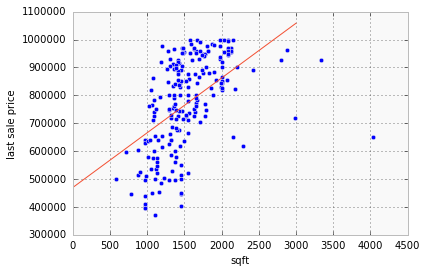

In [20]:
plt.scatter(df['SQFT'], df['LAST SALE PRICE'])
pm = 3000
plt.plot([0, pm], [f.predict([1,0])[0], f.predict([1, pm])[0]])
print f.rsquared
plt.ylabel('last sale price')
plt.xlabel('sqft')
plt.xlim(0,4500)
plt.show()

## First try

For a new problem, I typically get an initial fit just to see what I'm working with.  There's some obvious feature extraction and changes that need to be done, but the results will be looked at with dis-trust anyway, so let's just see what happens when we throw the data at the wall.  This is (arguably) a sloppy practice.  I personally choose to do it because even when my problem is ill-formed, and my solution suffers from <a href='https://en.wikipedia.org/wiki/Garbage_in,_garbage_out'>GIGO</a>, I often learn a bit from the diagnostics.  So let's take a skeptical look at an effortless model...

In [21]:
cols = ['intercept', 'BEDS', 'BATHS', 'SQFT', 'LOT SIZE', 'YEAR BUILT', 'PARKING SPOTS', 'IS SHORT SALE', 'intercept']
y = df['LAST SALE PRICE']
X = sm.add_constant(df[cols])
est = sm.OLS(y, X, missing='drop').fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LAST SALE PRICE   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     23.36
Date:                Fri, 19 Feb 2016   Prob (F-statistic):           2.98e-22
Time:                        15:37:07   Log-Likelihood:                -2404.8
No. Observations:                 184   AIC:                             4826.
Df Residuals:                     176   BIC:                             4851.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
intercept      1.564e+06    3.6e+05      4.346      0.000      8.54e+05  2.27e+06
BEDS           3000.4198   1.75e+04      0.172      0.864     -3.15e+04  3.75e+04
BATHS         -8768.2961   1.99e+04     -0.441      0.660      -4.8e+04  3.05e+04
SQFT            201.4324     32.084      6.278      0.000       138.113   264.751
LOT SIZE        -12.7093      2.897     -4.387      0.000       -18.427    -6.992
YEAR BUILT    -1317.1353    374.476     -3.517      0.001     -2056.176  -578.095
PARKING SPOTS   569.9497   6058.027      0.094      0.925     -1.14e+04  1.25e+04
IS SHORT SALE -2.337e+05   4.15e+04     -5.630      0.000     -3.16e+05 -1.52e+05
intercept      1.564e+06    3.6e+05      4.346      0.000      8.54e+05  2.27e+06
==============================================================================
Omnibus:                       11.927   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.351
Skew:                          -0.612   Prob(JB):                      0.00208
Kurtosis:                       3.335   Cond. No.                     2.24e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.94e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

First stat we check (and good fodder for a future episode) is the R^2.  My model explains about half of the variance, but for the limited dataset, this is weak.  My coefficients are clearly garbage.  Why would any of them be negative, except prehaps "is short sale"?  You should be skeptical of this model.  Let's make one more small attempt here and leave the real work for future posts.

## Feature extraction

In [23]:
# Convert to dummy variables, especially for baths which have a strange non-linear relationship.
df['Beds0'] = (df['BEDS'] == 0).astype(int)
df['Beds1'] = (df['BEDS'] == 1).astype(int)
df['Beds2'] = (df['BEDS'] == 2).astype(int)
df['Beds+'] = (df['BEDS'] >= 3).astype(int)
df['Baths0'] = (df['BATHS'] == 0).astype(int)
df['Baths1'] = (df['BATHS'] == 1).astype(int)
df['Baths2'] = (df['BATHS'] == 2).astype(int)
df['Baths+'] = (df['BATHS'] >= 3).astype(int)

In [24]:
cols = ['intercept', 'Beds0', 'Beds1', 'Beds2', 'Beds+', 'Baths0', 'Baths1', 'Baths2', 'Baths+', 'SQFT', 'LOT SIZE', 'YEAR BUILT', 'PARKING SPOTS', 'IS SHORT SALE', 'intercept']
y = df['LAST SALE PRICE']
X = sm.add_constant(df[cols])
est = sm.OLS(y, X, missing='drop').fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LAST SALE PRICE   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     19.17
Date:                Fri, 19 Feb 2016   Prob (F-statistic):           1.80e-23
Time:                        15:39:09   Log-Likelihood:                -2410.3
No. Observations:                 185   AIC:                             4843.
Df Residuals:                     174   BIC:                             4878.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
intercept      1.433e+06   2.71e+05      5.281      0.000      8.97e+05  1.97e+06
Beds0          -1.64e-06   3.09e-07     -5.303      0.000     -2.25e-06 -1.03e-06
Beds1          3.884e+05   1.22e+05      3.177      0.002      1.47e+05   6.3e+05
Beds2          5.085e+05   9.74e+04      5.219      0.000      3.16e+05  7.01e+05
Beds+          5.362e+05   9.79e+04      5.478      0.000      3.43e+05  7.29e+05
Baths0        -1.738e-10      3e-11     -5.791      0.000     -2.33e-10 -1.15e-10
Baths1        -6.238e+04   2.95e+04     -2.112      0.036     -1.21e+05 -4077.523
Baths2         1.655e+04   2.12e+04      0.781      0.436     -2.53e+04  5.84e+04
Baths+        -1.494e+04   2.84e+04     -0.527      0.599     -7.09e+04  4.11e+04
SQFT            153.8091     27.113      5.673      0.000       100.295   207.323
LOT SIZE        -14.9109      2.989     -4.989      0.000       -20.810    -9.012
YEAR BUILT    -1407.2552    325.684     -4.321      0.000     -2050.055  -764.455
PARKING SPOTS  -878.6629   5932.204     -0.148      0.882     -1.26e+04  1.08e+04
IS SHORT SALE -2.074e+05   4.09e+04     -5.065      0.000     -2.88e+05 -1.27e+05
intercept      1.433e+06   2.71e+05      5.281      0.000      8.97e+05  1.97e+06
==============================================================================
Omnibus:                        7.011   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                7.066
Skew:                          -0.479   Prob(JB):                       0.0292
Kurtosis:                       3.013   Cond. No.                     2.38e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.72e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Ok, my fit is better, but not much.  I see some extremely small coefficients, so if we like this feature set (that's still to be debated), we should apply L1 regression to refocus on the features that have predictive power.  More on all that in future episodes and blog posts!